# Avellaneda-Stoikov

In [1]:
import sys
sys.path.append("../") # This version of the notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from DRL4AMM.agents.BaselineAgents import *
from DRL4AMM.gym.TradingEnvironment import TradingEnvironment
from DRL4AMM.gym.helpers.generate_trajectory import generate_trajectory
from DRL4AMM.gym.helpers.plotting import *
from DRL4AMM.stochastic_processes.midprice_models import *
from DRL4AMM.stochastic_processes.arrival_models import *
from DRL4AMM.stochastic_processes.fill_probability_models import *
from DRL4AMM.rewards.RewardFunctions import InventoryAdjustedPnL

## Random strategy

In [2]:
terminal_time = 1.0
n_steps = 200
seed = 42
np.random.seed(seed)
timestamps = np.linspace(0, terminal_time, n_steps + 1)

env = TradingEnvironment(terminal_time=terminal_time, n_steps=n_steps, seed=seed)
random = RandomAgent(env,seed=seed)

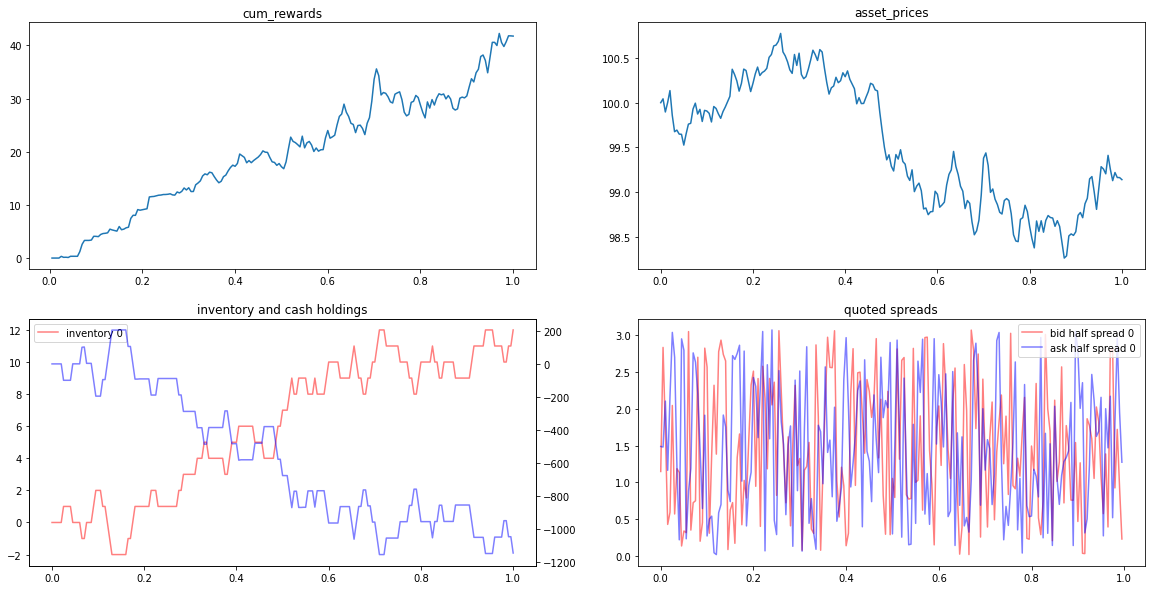

In [3]:
plot_trajectory(env, random, seed = seed)

## Fixed strategies

In [4]:
half_spreads = [0.25,0.5,1,2,4]

In [7]:
performance_dict = {}

for hs in half_spreads:
    np.random.seed(42)
    agent = FixedSpreadAgent(half_spread=hs)
    performance_dict[hs] = {}
    performance_dict[hs]["observations"], performance_dict[hs]["actions"], rewards = generate_trajectory(env,agent, seed = seed)
    performance_dict[hs]["cum_rewards"] = np.cumsum(rewards)

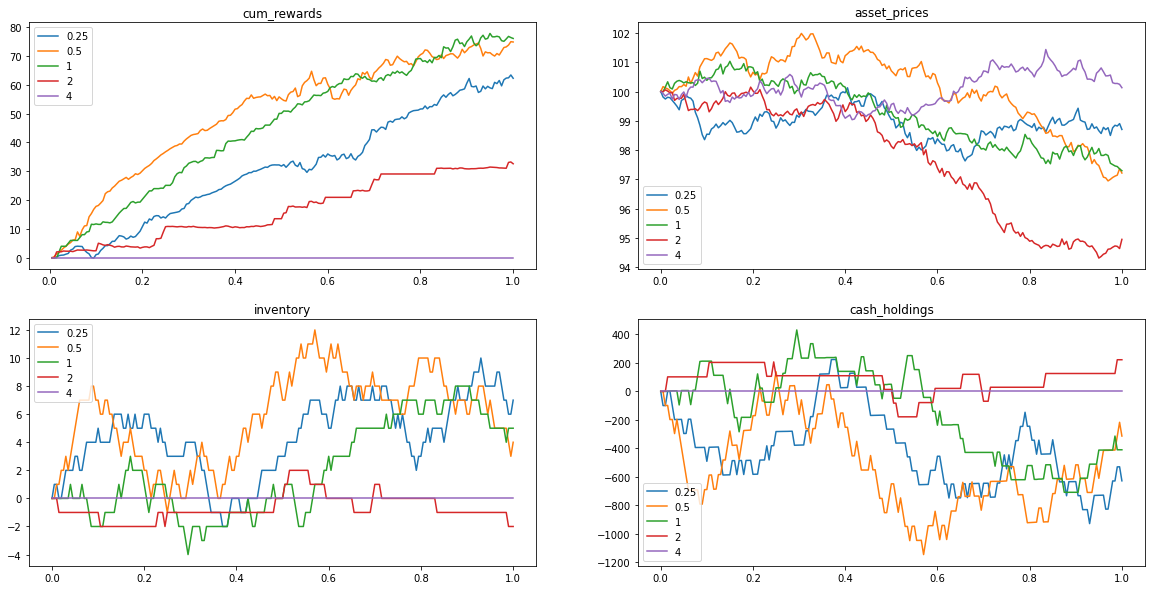

In [8]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))

ax1.title.set_text("cum_rewards")
ax2.title.set_text("asset_prices")
ax3.title.set_text("inventory")
ax4.title.set_text("cash_holdings")

for hs in half_spreads:
    ax1.plot(timestamps[1:],performance_dict[hs]["cum_rewards"], label = hs)
    ax2.plot(timestamps,performance_dict[hs]["observations"][:,3].reshape(-1), label = hs)
    ax3.plot(timestamps,performance_dict[hs]["observations"][:,1].reshape(-1), label = hs)
    ax4.plot(timestamps,performance_dict[hs]["observations"][:,0].reshape(-1), label = hs)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

## Avellaneda-Stoikov Optimal Strategy

In [9]:
def get_as_env(num_trajectories:int = 1):
    terminal_time = 1.0
    sigma = 2.0
    n_steps = 2000
    arrival_rate = 140
    fill_exponent = 1.5
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    return TradingEnvironment(terminal_time=terminal_time, 
                                 n_steps=n_steps, seed=seed, 
                                 num_trajectories=num_trajectories, 
                                 midprice_model=midprice_model,
                                 arrival_model=arrival_model, 
                                 fill_probability_model=fill_probability_model)

In [10]:
as_env = get_as_env()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

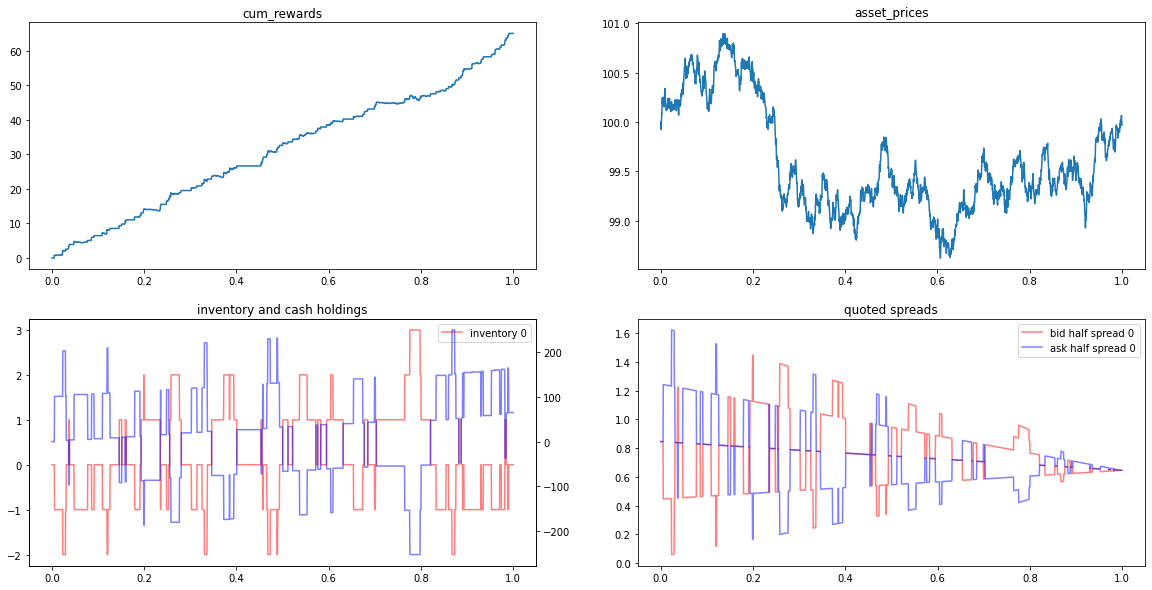

In [12]:
plot_trajectory(as_env, as_agent, seed = seed)

### Comparing the results to the Avellaneda Stoikov paper

In [13]:
num_trajectories = 100000
vec_env = get_as_env(num_trajectories)
vec_as = AvellanedaStoikovAgent(risk_aversion=0.1, env=vec_env)

In [14]:
observations, actions, rewards = generate_trajectory(vec_env, vec_as)

/home/paps/Documents/github/DRL4AMM/notebooks/../DRL4AMM/agents/BaselineAgents.py:63: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


In [26]:
results, fig, total_rewards = generate_results_table_and_hist(vec_env=vec_env,agent=vec_as)

In [28]:
results

,Mean spread,Mean PnL,Std PnL,Mean terminal inventory,Std terminal inventory
Inventory,1.49087,64.055507,7.227587,0.00335,3.369181


These results look similar to Table 2 of Avellaneda and Stoikov. It is interesting that the agent **does** quote a negative spread sometimes, which _could_ be interpreted as taking liquidity but then the model should possibly be changed.

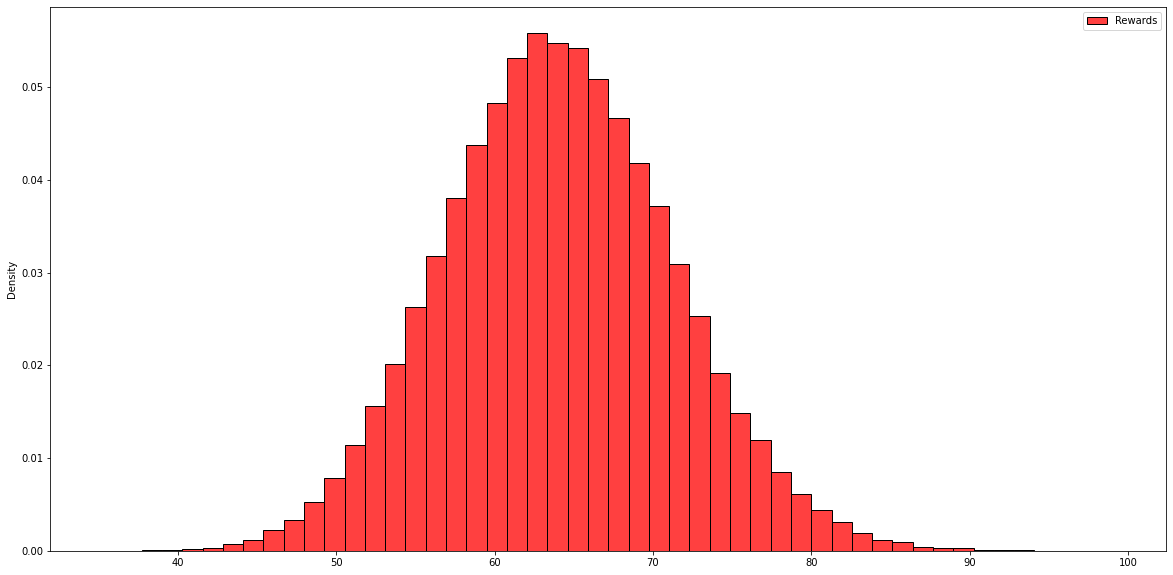

In [29]:
fig

### The effect of increasing risk aversion

In [30]:
risk_aversions = [0.01,0.1,0.5,1]

In [36]:
total_rewards_dict = dict()
for risk_aversion in risk_aversions:
    vec_as = AvellanedaStoikovAgent(risk_aversion=risk_aversion, env=vec_env)
    _,_,total_rewards_dict[risk_aversion] = generate_results_table_and_hist(vec_env=vec_env,agent=vec_as);   

/home/paps/Documents/github/DRL4AMM/notebooks/../DRL4AMM/agents/BaselineAgents.py:63: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")
/home/paps/Documents/github/DRL4AMM/notebooks/../DRL4AMM/agents/BaselineAgents.py:63: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")
/home/paps/Documents/github/DRL4AMM/notebooks/../DRL4AMM/agents/BaselineAgents.py:63: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


In [37]:
colors = ["r", "g", "b", "c"]

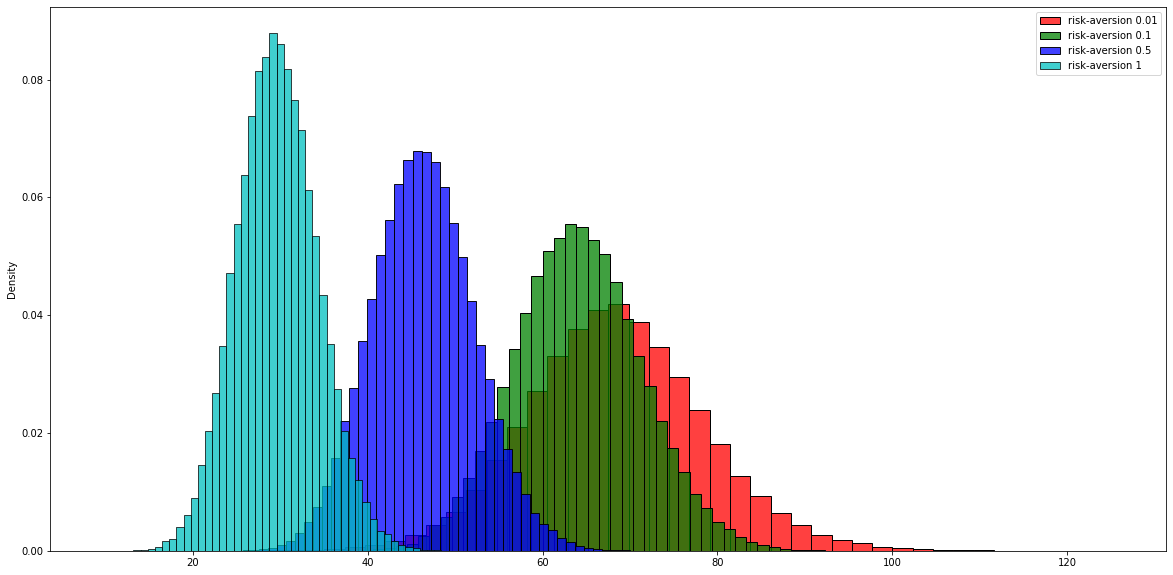

In [38]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
for risk_aversion, color in zip(risk_aversions,colors):
    sns.histplot(total_rewards_dict[risk_aversion], label=f"risk-aversion {risk_aversion}", stat = "density", bins = 50, ax=ax, color=color)
ax.legend()
plt.show()

**Note, it is hard to argue that the risk-averse agent is outperforming the non risk-averse agent in these cases...**

## The Cartea-Jaimungal agent

In [22]:
cj_agent = CarteaJaimungalAgent(phi=0.1, alpha=0.001,env=as_env, max_inventory=100)

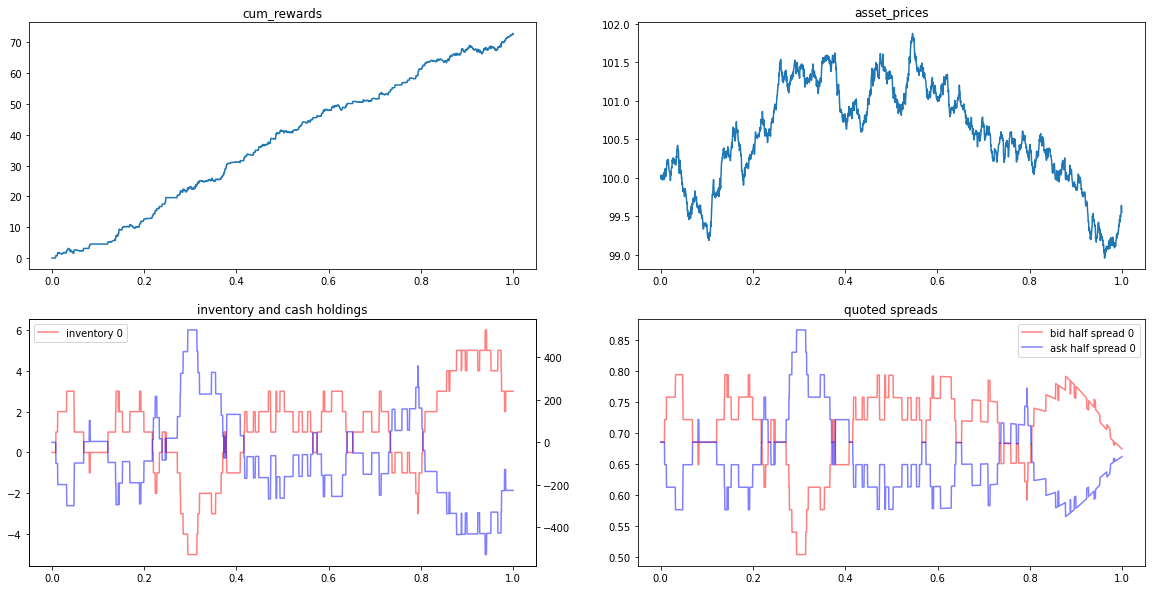

In [21]:
plot_trajectory(as_env, cj_agent, seed = seed)